In [1]:
import numpy as np
from tqdm.notebook import tqdm
import os
from PIL import Image
import math
import logging
from tqdm import tqdm, trange
from numba import njit

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Define a small constant for float comparisons, compatible with Numba
FLOAT_TOLERANCE = 1e-8
TOL = 1e-4



In [2]:
# --- Вспомогательные функции (njit) - Упорядочены по зависимостям ---
@njit  # Применяем njit для скалярного произведения (используется в Грам-Шмидте и Хаусхолдере)
def dot_product_njit(v1, v2):
    """Вычисляет скалярное произведение двух векторов NumPy с использованием Numba."""
    return np.sum(v1 * v2)

@njit  # Применяем njit для нормы
def norm(k):  # евклидова норма
    """Вычисляет евклидову норму вектора NumPy с использованием Numba."""
    return np.sqrt(np.sum(k * k))

@njit  # Применяем njit для вычитания векторов
def subtract_vectors_njit(vector1, vector2):
    """Вычитает два вектора NumPy с использованием Numba."""
    result = np.zeros_like(vector1)
    for i in range(len(vector1)):
        result[i] = vector1[i] - vector2[i]
    return result

@njit  # Применяем njit для умножения вектора на скаляр
def scalar_multiply_vector_njit(scalar, vector):
    """Умножает вектор NumPy на скаляр с использованием Numba."""
    result = np.zeros_like(vector)
    for i in range(len(vector)):
        result[i] = scalar * vector[i]
    return result

@njit  # njit-функция для умножения матрицы на скаляр
def scalar_multiply_matrix_njit(scalar, matrix):
    """Умножает матрицу NumPy на скаляр с использованием Numba."""
    rows, cols = matrix.shape
    result = np.zeros_like(matrix)
    for i in range(rows):
        for j in range(cols):
            result[i, j] = scalar * matrix[i, j]
    return result

@njit  # Применяем njit для вычитания матриц
def subtract_matrices_njit(matrix1, matrix2):
    """Вычитает две матрицы NumPy с использованием Numba."""
    rows1, cols1 = matrix1.shape
    result = np.zeros_like(matrix1)
    for i in range(rows1):
        for j in range(cols1):
            result[i, j] = matrix1[i, j] - matrix2[i, j]
    return result

@njit  # Применяем njit для умножения матриц
def multiply_matrices_njit(matrix1, matrix2):
    """Умножает две матрицы NumPy с использованием Numba."""
    rows1, cols1 = matrix1.shape
    rows2, cols2 = matrix2.shape
    result = np.zeros((rows1, cols2), dtype=matrix1.dtype)
    for i in range(rows1):
        for j in range(cols2):
            for k in range(cols1):
                result[i, j] += matrix1[i, k] * matrix2[k, j]
    return result

@njit  # Применяем njit для транспонирования матрицы
def transpose_matrix_njit(matrix):
    """Транспонирует матрицу NumPy с использованием Numba и NumPy."""
    return np.transpose(matrix)


@njit  # Применяем njit для создания диагональной матрицы
def create_diagonal_matrix_njit(values):
    """Создает диагональную матрицу NumPy из одномерного массива."""
    size = len(values)
    matrix = np.zeros((size, size), dtype=values.dtype)
    for i in range(size):
        matrix[i, i] = values[i]
    return matrix

@njit  # Применяем njit для инвертирования диагональной матрицы
def invert_diagonal_matrix_njit(matrix):
    """Инвертирует диагональную матрицу NumPy."""
    size = matrix.shape[0]
    result = np.zeros_like(matrix)
    for i in range(size):
        if abs(matrix[i, i]) < FLOAT_TOLERANCE:  # Используем константу
            return np.full_like(matrix, np.nan)  # Матрица с NaN в случае ошибки
        result[i, i] = 1.0 / matrix[i, i]
    return result

@njit  # Применяем njit к решателю методом Гаусса
def solve_gauss_njit(A, b):
    """
    Решает СЛАУ Ax = b методом Гаусса с частичным выбором ведущего элемента.
    Принимает массивы NumPy, возвращает вектор NumPy.
    """
    n = A.shape[0]
    augmented_matrix = np.zeros((n, n + 1), dtype=A.dtype)
    augmented_matrix[:, :n] = A.copy()
    augmented_matrix[:, n] = b.copy()

    for i in range(n):
        # Частичный выбор ведущего элемента
        pivot_row = i
        max_val = abs(augmented_matrix[i, i])
        for k in range(i + 1, n):
            current_val = abs(augmented_matrix[k, i])
            if current_val > max_val:
                max_val = current_val
                pivot_row = k

        if max_val < FLOAT_TOLERANCE:  # Матрица вырождена
            return np.full(n, np.nan, dtype=A.dtype)

        # Меняем строки местами
        temp_row = np.copy(augmented_matrix[i, :])
        augmented_matrix[i, :] = augmented_matrix[pivot_row, :]
        augmented_matrix[pivot_row, :] = temp_row

        # Нормализация текущей строки
        pivot_element = augmented_matrix[i, i]
        for j in range(i, n + 1):
            augmented_matrix[i, j] /= pivot_element

        # Элиминация элементов ниже ведущего
        for row_idx in range(n):
            if row_idx != i:
                factor = augmented_matrix[row_idx, i]
                for col_idx in range(i, n + 1):
                    augmented_matrix[row_idx, col_idx] -= factor * augmented_matrix[i, col_idx]

    # Обратная подстановка
    x = np.zeros(n, dtype=A.dtype)
    for i in range(n - 1, -1, -1):
        sum_of_terms = 0.0
        for j in range(i + 1, n):
            sum_of_terms += augmented_matrix[i, j] * x[j]
        if abs(augmented_matrix[i, i]) < FLOAT_TOLERANCE:
            return np.full(n, np.nan, dtype=A.dtype)
        x[i] = (augmented_matrix[i, n] - sum_of_terms) / augmented_matrix[i, i]
    return x


@njit  # Применяем njit для вычисления обратной матрицы
def inverse_matrix_njit(A):
    """
    Вычисляет обратную матрицу для массива NumPy с использованием метода Гаусса.
    """
    n = A.shape[0]
    I = np.eye(n, dtype=A.dtype)
    A_inv = np.zeros((n, n), dtype=A.dtype)

    for i in range(n):
        e = I[:, i]
        col_i_inv = solve_gauss_njit(A, e)
        if np.any(np.isnan(col_i_inv)):
            return np.full_like(A, np.nan)
        A_inv[:, i] = col_i_inv
    return A_inv

@njit  # Применяем njit для LU-разложения
def lu_decomp_njit(A):
    """
    Выполняет LU-разложение матрицы (A = L @ U).
    Примечание: базовая версия без выбора ведущего элемента.
    """
    n = A.shape[0]
    L = np.zeros_like(A)
    U = A.copy()

    for i in range(n):
        if abs(U[i, i]) < FLOAT_TOLERANCE:
            return np.full_like(A, np.nan), np.full_like(A, np.nan)
        L[i, i] = 1.0

        for j in range(i + 1, n):
            factor = U[j, i] / U[i, i]
            L[j, i] = factor
            U[j] -= factor * U[i]

    return L, U


@njit  # Применяем njit для решения СЛАУ через LU-разложение
def solve_lu_njit(L, U, b):
    """
    Решает системы Ly = b и Ux = y.
    """
    n = L.shape[0]
    y = np.zeros(n, dtype=b.dtype)

    # Прямая подстановка (Ly = b)
    for i in range(n):
        sum_terms = 0.0
        for j in range(i):
            sum_terms += L[i, j] * y[j]
        if abs(L[i, i]) < FLOAT_TOLERANCE:
            return np.full_like(b, np.nan)
        y[i] = (b[i] - sum_terms) / L[i, i]

    # Обратная подстановка (Ux = y)
    x = np.zeros(n, dtype=b.dtype)
    for i in range(n - 1, -1, -1):
        sum_terms = 0.0
        for j in range(i + 1, n):
            sum_terms += U[i, j] * x[j]
        if abs(U[i, i]) < FLOAT_TOLERANCE:
            return np.full_like(b, np.nan)
        x[i] = (y[i] - sum_terms) / U[i, i]

    return x

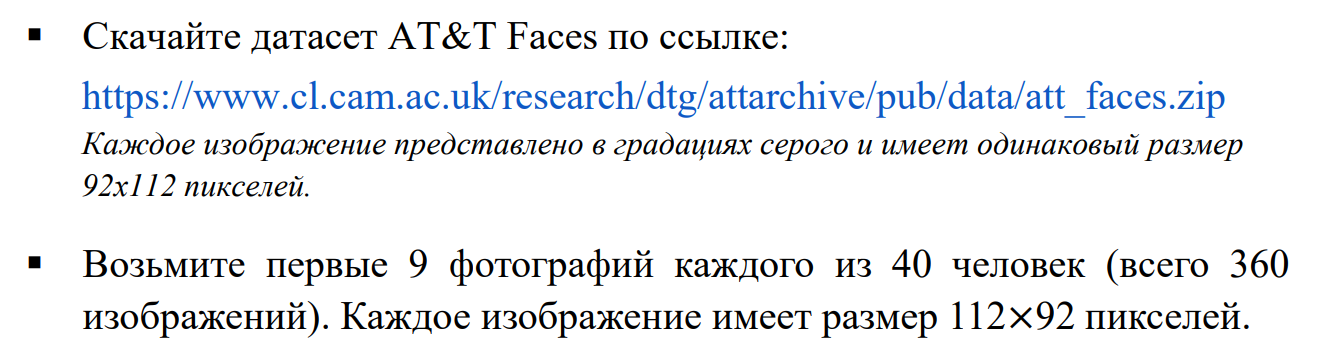

In [3]:
def load_att_faces(dataset_path):
    """
    Загружает датасет AT&T Faces из указанного пути.

    Args:
        dataset_path (str): Путь к корневой папке датасета (например, 'data/att_faces/').

    Returns:
        tuple: Кортеж, содержащий два списка:
               - images: Список numpy массивов, представляющих изображения.
               - labels: Список целых чисел, представляющих метки (индексы людей).
    """
    images = []
    labels = []
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    person_id = 0
    for person_folder in tqdm(sorted(os.listdir(dataset_path)),'loading people images'):
        person_path = os.path.join(dataset_path, person_folder)
        if os.path.isdir(person_path):
            k = 0
            for image_file in sorted(os.listdir(person_path)):

                image_path = os.path.join(person_path, image_file)
                try:
                    k += 1
                    # Открываем изображение (предполагается формат PGM)
                    img = Image.open(image_path).convert('L')  # Конвертируем в оттенки серого
                    # Преобразуем изображение в numpy массив
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(person_id)
                    if k!=10:
                        train_images.append(img_array)
                        train_labels.append(person_id)
                    else:
                        test_images.append(img_array)
                        test_labels.append(person_id)
                except Exception as e:
                    print(f"Не удалось загрузить изображение: {image_path}. Ошибка: {e}")
            person_id += 1

    images, labels, train_images, train_labels, test_images, test_labels = np.array (images), np.array(labels), np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)
    return images, labels, train_images, train_labels, test_images, test_labels

# Загружаем датасет
images, labels, train_images, train_labels, test_images, test_labels = load_att_faces('data/att_faces/')

loading people images: 100%|██████████| 41/41 [00:00<00:00, 549.26it/s]


In [4]:
print(f"Количество загруженных изображений: {len(images)}")
print(f"Количество меток: {len(labels)}")
print(f"Форма первого изображения: {images[0].shape}")
print(f"Метка первого изображения: {labels[0]}")

Количество загруженных изображений: 400
Количество меток: 400
Форма первого изображения: (112, 92)
Метка первого изображения: 0


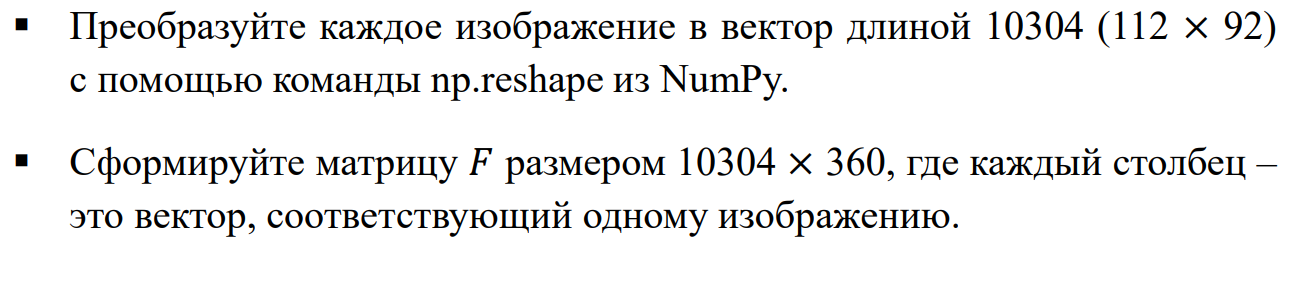

In [5]:
F = []
test_images_ravel = []

for i in range(len(train_images)):
    F.append((train_images[i].flatten()))

for i in range(len(test_images)):
    test_images_ravel.append((test_images[i].flatten()))

F = np.array(F).T
test_images_ravel = np.array(test_images_ravel).T

F.shape

(10304, 360)

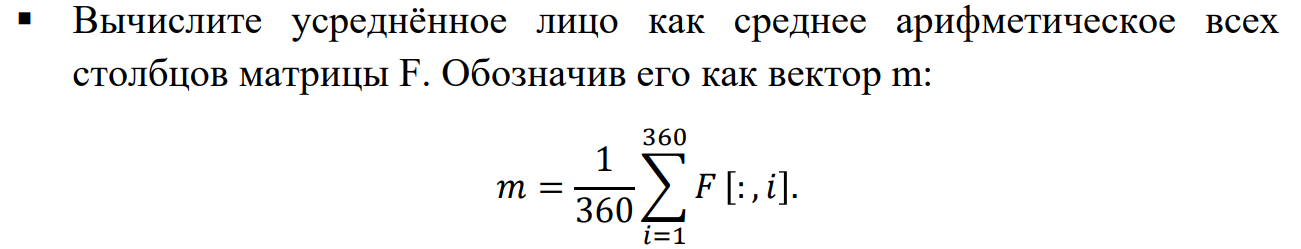

In [6]:
m = F.mean(axis=1)

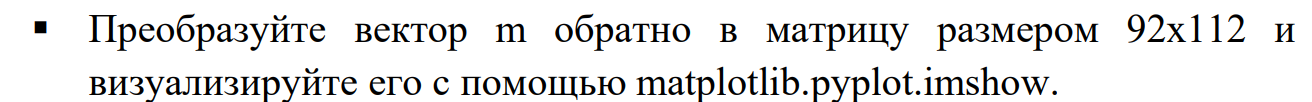

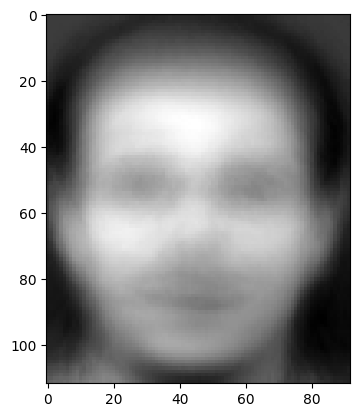

In [7]:
import matplotlib.pyplot as plt
plt.imshow(m.reshape((112, 92)),cmap='grey')
plt.show()

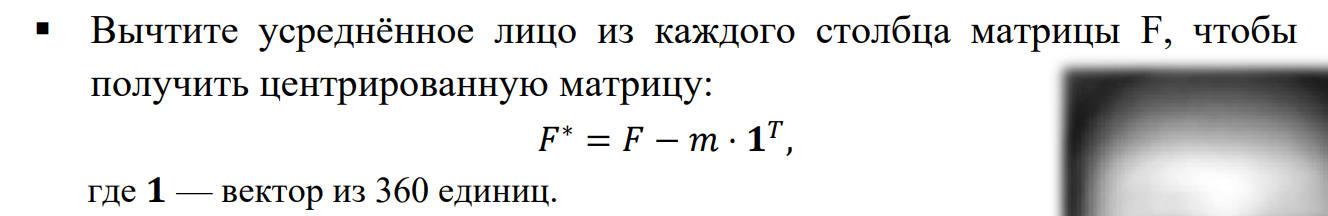

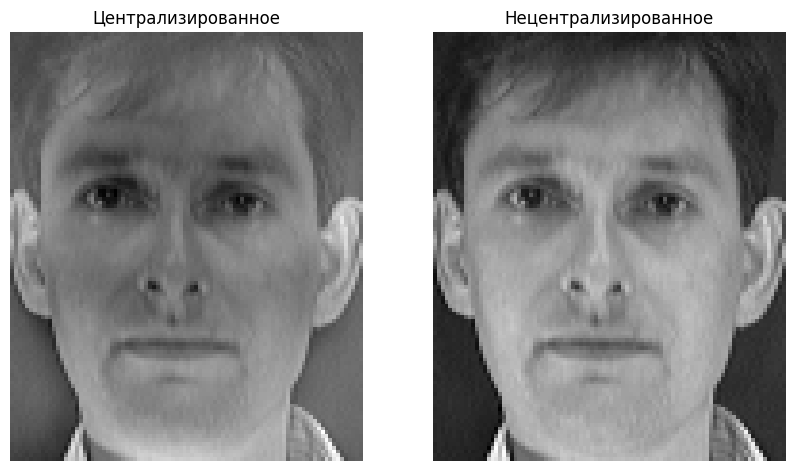

In [8]:
F_star = F - np.repeat(m,F.shape[1]).reshape(10304,360)

idx = 151
imges_to_show = [F_star[:,idx].reshape((112, 92)),F[:,idx].reshape((112, 92))]
labels = ['Централизированное', 'Нецентрализированное']
plt.figure(figsize=(10, 8))
for i in range(1,3):
    plt.subplot(1, 2, i)
    plt.imshow(imges_to_show[i-1], cmap='grey')
    plt.title(labels[i-1])
    plt.axis('off')

plt.show()

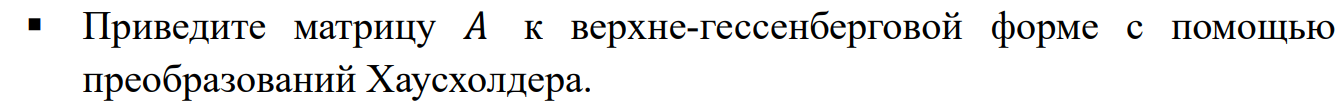

In [9]:
@njit  # Применяем njit для построения отражения Хаусхолдера
def householder_reflection_njit(vector):
    """Строит матрицу отражения Хаусхолдера для вектора NumPy."""
    n = len(vector)
    e1 = np.zeros(n, dtype=vector.dtype)
    if n > 0:
        e1[0] = 1.0
    vec_norm = norm(vector)
    v = subtract_vectors_njit(vector, scalar_multiply_vector_njit(vec_norm, e1))
    v_norm_sq = dot_product_njit(v, v)

    if v_norm_sq < FLOAT_TOLERANCE:
        return np.eye(n, dtype=vector.dtype)

    outer_product = np.zeros((n, n), dtype=vector.dtype)
    for i in range(n):
        for j in range(n):
            outer_product[i, j] = v[i] * v[j]

    scaled_outer_product = scalar_multiply_matrix_njit(2.0 / v_norm_sq, outer_product)
    P = subtract_matrices_njit(np.eye(n, dtype=vector.dtype), scaled_outer_product)
    return P

@njit  # Применяем njit к применению преобразований Хаусхолдера
def apply_householder_to_matrix_njit(matrix, start_col):
    """Приводит матрицу к верхней хессенберговой форме через преобразования Хаусхолдера."""
    n = matrix.shape[0]
    Q_acc = np.eye(n, dtype=matrix.dtype)

    for k in range(start_col, n - 2):
        v_segment = matrix[k + 1:, k]
        if v_segment.size == 0 or np.all(np.abs(v_segment) < FLOAT_TOLERANCE):
            continue

        H_sub = householder_reflection_njit(v_segment)
        H = np.eye(n, dtype=matrix.dtype)
        H[k + 1:, k + 1:] = H_sub

        matrix = multiply_matrices_njit(H, matrix)
        Q_acc = multiply_matrices_njit(Q_acc, H)

    return matrix, Q_acc
# --- Приведение к форме Хессенберга методом Хаусхолдера (Не njit - использует NumPy напрямую) ---
# Примечание: Для симметричных матриц (например, A = F.T @ F) реализация приводит к тридиагональной форме,
# что корректно для данного типа задач.

def Householder(X):
    """
    Приводит симметричную матрицу к тридиагональной форме с помощью отражений Хаусхолдера.
    Использует NumPy для выполнения операций.
    """
    logging.info("Начало приведения матрицы к тридиагональной форме методом Хаусхолдера.")
    B = X.copy()
    n = B.shape[0]
    # Основной цикл приведения с прогресс-баром
    for i in tqdm(range(n-1), desc="Приведение Хаусхолдера", leave=False):
        # Выделяем подстолбец под диагональю
        x = B[i+1:, i].copy()  # Создаем копию для избежания ссылок

        # Вычисляем длину вектора с учетом направления для зануления
        sigma = -1 * np.sign(x[0]) * np.sqrt(np.sum(x**2)) if x[0] != 0 else -np.sqrt(np.sum(x**2))

        # Формируем вспомогательный вектор с первым ненулевым элементом
        se = np.zeros_like(x)
        se[0] = sigma

        # Строим отражающий вектор
        v = x - se
        vn = np.linalg.norm(v)  # Норма вектора

        # Пропускаем итерацию при нулевом векторе (защита от деления на ноль)
        if vn < TOL:
            logging.debug(f"Пропуск отражения Хаусхолдера на итерации {i} из-за нулевого вектора.")
            continue

        v = v / vn  # Нормализация
        v = v.reshape(-1, 1)  # Преобразуем в вектор-столбец

        # Формируем матрицу отражения Хаусхолдера для подматрицы
        H = np.eye(len(x)) - 2 * v @ v.T

        # Расширяем матрицу отражения до размера исходной матрицы
        Hp = np.eye(n)
        Hp[i+1:, i+1:] = H

        # Применяем двустороннее преобразование (сохраняет спектр)
        B = Hp @ B @ Hp
    logging.info("Приведение к тридиагональной форме завершено.")
    return B

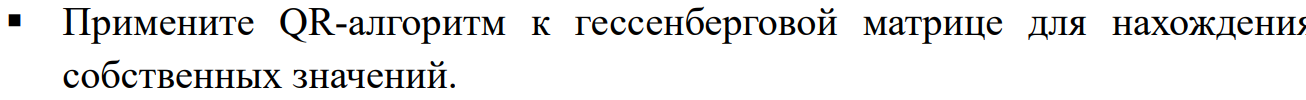

In [10]:
@njit  # Применяем njit к QR-разложению (Грам-Шмидт)
def QR_dec(A):
    """
    Выполняет QR-разложение матрицы NumPy методом Грама-Шмидта.
    """
    n, m = A.shape
    Q = np.zeros((n, m), dtype=np.float64)
    R = np.zeros((m, m), dtype=np.float64)

    for i in range(m):
        u = A[:, i].copy()
        for j in range(i):
            proj_scalar = dot_product_njit(Q[:, j], u)
            proj = scalar_multiply_vector_njit(proj_scalar, Q[:, j])
            u = subtract_vectors_njit(u, proj)
        u_norm = norm(u)

        if u_norm < FLOAT_TOLERANCE:
            Q[:, i] = np.zeros(n, dtype=A.dtype)
            R[i, i] = 0.0
        else:
            Q[:, i] = u / u_norm
            for j in range(i + 1):
                R[j, i] = dot_product_njit(Q[:, j], A[:, i])

    return Q, R


@njit  # Применяем njit к шагу QR-алгоритма
def QR_step_njit(Ak):
    """Выполняет один шаг базового QR-алгоритма (Ak+1 = Rk @ Qk)."""
    Q, R = QR_dec(Ak)
    return multiply_matrices_njit(R, Q)

@njit  # Применяем njit к шагу QR-алгоритма со сдвигом
def QR_step_shift_njit(Ak):
    """Выполняет один шаг QR-алгоритма с одним сдвигом."""
    mu = Ak[-1, -1]
    n = Ak.shape[0]
    identity = np.zeros_like(Ak)
    for i in range(n):
        identity[i, i] = 1.0
    Ak_shifted = subtract_matrices_njit(Ak, scalar_multiply_matrix_njit(mu, identity))
    Q, R = QR_dec(Ak_shifted)
    return subtract_matrices_njit(multiply_matrices_njit(R, Q), scalar_multiply_matrix_njit(-mu, identity))

# --- QR-алгоритм (Не njit - использует tqdm и вызывает njit-функции) ---

def QR_alg(A, tol=1e-9, miter=1000):
    """
    Выполняет QR-алгоритм с сдвигами для нахождения собственных значений матрицы NumPy.
    Принимает массив NumPy и возвращает массив NumPy с собственными значениями.
    """
    logging.info(f"Начало QR-алгоритма для нахождения собственных значений (макс. итераций: {miter}, допуск: {tol}).")
    Ak = A.copy()
    n = A.shape[0]
    # Используем trange для отображения прогресса итераций
    for _ in trange(miter, desc="QR-алгоритм", leave=False):
        # Проверка сходимости (внедиагональные элементы малы)
        off_diagonal_elements = np.diag(Ak, k=-1)  # Получаем поддиагональные элементы
        if np.all(np.abs(off_diagonal_elements) < tol):
            logging.debug(f"QR-алгоритм сошелся за {_} итераций.")
            break
        # Выполняем шаг QR с сдвигом
        Ak = QR_step_shift_njit(Ak)  # Вызов njit-функции
    else:  # Этот блок выполняется, если цикл завершился без прерывания
        logging.warning(f"QR-алгоритм не сошелся за {miter} итераций.")

    # Собственные значения находятся на диагонали после сходимости (или макс. итераций)
    eigenvalues = np.array([Ak[i, i] for i in range(n)])  # Извлекаем диагональные элементы
    logging.info("QR-алгоритм завершен.")
    return eigenvalues  # возвращаем как массив NumPy

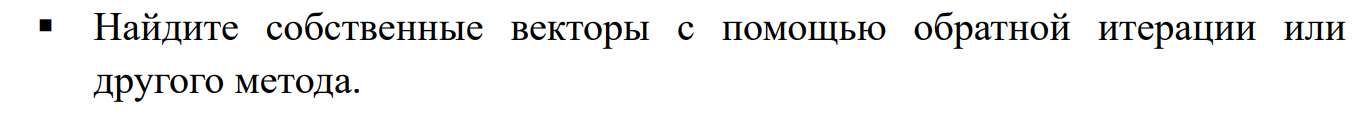

In [11]:
@njit  # Применяем njit к методу обратных итераций с частным Рэлея
def rayleigh_inv_iter_njit(A, eigenvalue, tol=1e-10, max_iter=100, additional_iter = 100):
    """
    Выполняет метод обратных итераций с частным Рэлея для нахождения собственного вектора.
    Использует LU-разложение. Принимает массивы NumPy.
    """
    n = A.shape[0]
    x = np.ones(n, dtype=A.dtype)
    x_norm = norm(x)
    if x_norm < FLOAT_TOLERANCE:
        return np.full(n, np.nan, dtype=A.dtype)
    x /= x_norm
    mu = eigenvalue

    for i in range(max_iter):
        identity = np.zeros_like(A)
        for j in range(n):
            identity[j, j] = 1.0
        B = subtract_matrices_njit(A, scalar_multiply_matrix_njit(mu, identity))
        L, U = lu_decomp_njit(B)

        if np.any(np.isnan(L)) or np.any(np.isnan(U)):
            return np.full(n, np.nan, dtype=A.dtype)

        y = solve_lu_njit(L, U, x)
        y_norm = norm(y)
        if y_norm < FLOAT_TOLERANCE:
            break
        x_new = scalar_multiply_vector_njit(1.0 / y_norm, y)
        diff_norm = norm(subtract_vectors_njit(x_new, x))

        if diff_norm < tol:
            break
        x = x_new
        
    if np.any(np.isnan(x)):
        for i in range(additional_iter):
            identity = np.zeros_like(A)
            for j in range(n):
                identity[j, j] = 1.0
            B = subtract_matrices_njit(A, scalar_multiply_matrix_njit(mu, identity))
            L, U = lu_decomp_njit(B)

            if np.any(np.isnan(L)) or np.any(np.isnan(U)):
                return np.full(n, np.nan, dtype=A.dtype)

            y = solve_lu_njit(L, U, x)
            y_norm = norm(y)
            if y_norm < FLOAT_TOLERANCE:
                break
            x_new = scalar_multiply_vector_njit(1.0 / y_norm, y)
            diff_norm = norm(subtract_vectors_njit(x_new, x))

            if diff_norm < tol:
                break
            x = x_new
    


    x[np.isnan(x)] = TOL

    return x

In [12]:
# --- Вычисление ортонормированного базиса (Не njit - использует tqdm и вызывает njit-функции) ---
# Реализация использует ортогонализацию Грама-Шмидта для вычисленных собственных векторов.
EPSILON = 1e-8
def compute_orthonormal_basis(A, eigenvalues, tol=1e-10, max_iter=100):
    """
    Вычисляет ортонормированный базис собственных векторов для матрицы A
    методом обратных итераций и ортогонализацией Грама-Шмидта.

    Добавляет небольшую константу, чтобы избежать вырождения векторов.

    Параметры:
        A (np.ndarray): Квадратная матрица размера (n, n).
        eigenvalues (iterable): Приближения собственных значений.
        tol (float): Допуск для сходимости обратных итераций.
        max_iter (int): Максимум итераций в обратной итерации.

    Возвращает:
        np.ndarray: Матрица собственных векторов (столбцы), ортонормированная.
    """
    logging.info("Начало вычисления ортонормированного базиса собственных векторов.")
    n = A.shape[0]
    basis = []

    for idx in trange(len(eigenvalues), desc="Ортонормирование векторов", leave=False):
        mu = eigenvalues[idx]
        v = rayleigh_inv_iter_njit(A, mu, tol, max_iter)
        

        v[np.isnan(v)] = TOL
        if np.any(np.isnan(v)):
            logging.warning(f"Обратная итерация не удалась для собственного значения {mu}. Пропуск.")
            continue

        # Грам-Шмидт
        for b in basis:
            proj = np.dot(b, v)
            v -= proj * b

        # Добавляем малую константу для предотвращения полного обнуления
        v += EPSILON

        norm_v = np.linalg.norm(v)
        while norm_v < FLOAT_TOLERANCE:
            
            logging.warning(f"Вектор для {mu} слишком мал после ортонормализации, даже с EPSILON. Увеличиваю EPSILON.")
            v += EPSILON
            norm_v = np.linalg.norm(v)
            

        v /= norm_v
        basis.append(v)

    if not basis:
        logging.error("Не найдено ни одного ненулевого собственного вектора.")
        return np.zeros((n, 0), dtype=A.dtype)

    Q = np.column_stack(basis)
    logging.info("Вычисление ортонормированного базиса завершено.")
    return Q

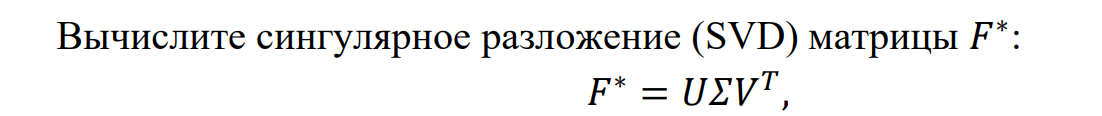

In [13]:
# Выполнение SVD


logging.info("Начало вычисления SVD (структурированный подход с njit и NumPy).")

# Преобразование входных данных в NumPy массив для внутренней обработки
if isinstance(F_star, list):
    logging.info("Преобразование входного списка списков в NumPy массив.")
    F_star_np = np.array(F_star, dtype=np.float64)  # Используем float64 для повышения точности
elif isinstance(F_star, np.ndarray):
    logging.info("Использование входного NumPy массива.")
    F_star_np = F_star.astype(np.float64)  # Гарантируем тип данных float64
else:
    raise TypeError("Входная матрица F_star должна быть списком списков или NumPy массивом.")

# Проверка размерности
if F_star_np.ndim != 2 or F_star_np.size == 0:
        raise ValueError("Входная матрица F_star должна быть непустой двумерной матрицей.")

# Основные этапы вычислений с прогресс-баром
steps = [
    "Вычисление A = F*ᵀ × F*",
    "Приведение A к тридиагональной форме (Хаусхолдер)",
    "Нахождение собственных значений A (QR-алгоритм)",
    "Нахождение собственных векторов A (обратная итерация)",
    "Вычисление сингулярных значений",
    "Вычисление левых сингулярных векторов U",
    "Транспонирование V для получения VT"  # Явное указание этапа VT
]

with tqdm(total=len(steps), desc="Процесс SVD") as pbar:

    # Этап 1: Вычисление матрицы A = F_star.T @ F_star
    logging.info(f"Этап 1: {steps[0]}")
    A = F_star_np.T @ F_star_np
    pbar.update(1)
    logging.info("Этап 1 завершен.")

    # Этап 2: Приведение к тридиагональной форме методом Хаусхолдера
    logging.info(f"Этап 2: {steps[1]}")
    H = Householder(A)  # Функция содержит собственный прогресс-бар
    assert all([all([round(H[i][j],5)==0 for j in range(0, i-1)]) for i in range(2, len(H))]), 'Неправильное преобразование хаусхолдера'
    pbar.update(1)
    logging.info("Этап 2 завершен.")

    # Этап 3: Нахождение собственных значений матрицы H через QR-алгоритм
    logging.info(f"Этап 3: {steps[2]}")
    eigenvalues_A = QR_alg(H, miter=500, tol=FLOAT_TOLERANCE)  # QR_alg содержит trange

    # Сортировка собственных значений по убыванию
    logging.info("Сортировка собственных значений.")
    sorted_indices = np.argsort(eigenvalues_A)[::-1]
    sorted_eigenvalues_A = eigenvalues_A[sorted_indices]
    # Гарантия неотрицательности (так как A = F*ᵀF*)
    sorted_eigenvalues_A = np.maximum(0.0, sorted_eigenvalues_A.real)
    pbar.update(1)
    logging.info("Этап 3 завершен.")

    # Этап 4: Нахождение собственных векторов A с ортогонализацией
    logging.info(f"Этап 4: {steps[3]}")
    eigenvectors_A = compute_orthonormal_basis(A, sorted_eigenvalues_A)  # Содержит trange
    pbar.update(1)
    logging.info("Этап 4 завершен.")

    # Этап 5: Сингулярные значения = sqrt(собственных значений)
    logging.info(f"Этап 5: {steps[4]}")
    singular_values = np.sqrt(sorted_eigenvalues_A)
    pbar.update(1)
    logging.info("Этап 5 завершен.")

    # Этап 6: Левые сингулярные векторы U = F_star × V × Σ⁻¹
    logging.info(f"Этап 6: {steps[5]}")
    V = eigenvectors_A  # Матрица V в SVD совпадает с собственными векторами A

    # Создание обратной диагональной матрицы сингулярных значений
    Sigma_diag = np.sqrt(sorted_eigenvalues_A)
    # Обработка деления на ноль
    if np.any(np.abs(Sigma_diag) < FLOAT_TOLERANCE):
        logging.warning("Обнаружены сингулярные значения, близкие к нулю. Корректировка обратной матрицы.")
        Sigma_diag_inv = np.zeros_like(Sigma_diag)
        non_zero = np.abs(Sigma_diag) >= FLOAT_TOLERANCE
        Sigma_diag_inv[non_zero] = 1.0 / Sigma_diag[non_zero]
    else:
        Sigma_diag_inv = 1.0 / Sigma_diag

    Sigma_inv = np.diag(Sigma_diag_inv)

    # Вычисление U
    F_star_V = F_star_np @ V
    U = F_star_V @ Sigma_inv
    pbar.update(1)
    logging.info("Этап 6 завершен.")

    # Этап 7: Транспонирование V для получения VT
    logging.info(f"Этап 7: {steps[6]}")
    VT = V.T
    pbar.update(1)
    logging.info("Этап 7 завершен.")

logging.info("Вычисление SVD завершено.")

2025-04-30 11:59:47,171 - INFO - Начало вычисления SVD (структурированный подход с njit и NumPy).
2025-04-30 11:59:47,173 - INFO - Использование входного NumPy массива.
Процесс SVD:   0%|          | 0/7 [00:00<?, ?it/s]2025-04-30 11:59:47,180 - INFO - Этап 1: Вычисление A = F*ᵀ × F*
2025-04-30 11:59:47,196 - INFO - Этап 1 завершен.
2025-04-30 11:59:47,197 - INFO - Этап 2: Приведение A к тридиагональной форме (Хаусхолдер)
2025-04-30 11:59:47,198 - INFO - Начало приведения матрицы к тридиагональной форме методом Хаусхолдера.
2025-04-30 11:59:47,785 - INFO - Приведение к тридиагональной форме завершено.
Процесс SVD:  29%|██▊       | 2/7 [00:00<00:01,  2.59it/s]2025-04-30 11:59:47,954 - INFO - Этап 2 завершен.
2025-04-30 11:59:47,954 - INFO - Этап 3: Нахождение собственных значений A (QR-алгоритм)
2025-04-30 11:59:47,955 - INFO - Начало QR-алгоритма для нахождения собственных значений (макс. итераций: 500, допуск: 1e-08).
2025-04-30 12:01:31,878 - WARNING - QR-алгоритм не сошелся за 500 ит

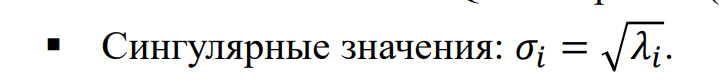

In [14]:
print("\nСингулярные значения (s) (NumPy array):")
# Print only a part for large arrays
if len(Sigma_diag) > 10:
    print(Sigma_diag[:10])
else:
    print(Sigma_diag)


Сингулярные значения (s) (NumPy array):
[32009.84171146 27329.97481562 19908.81125501 17720.76358023
 17112.28888364 13830.16727749 11889.48933188 11661.87781615
 10672.16150173 10271.41099084]


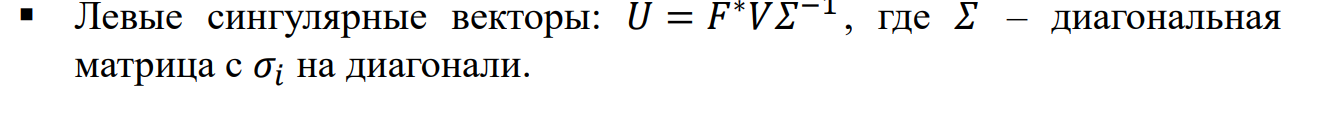

In [36]:
print("\nМатрица U (NumPy array):")
# Частичный вывод для больших матриц
if U.shape[0] > 10 or U.shape[1] > 10:
    print(U[:10, :10])
else:
    print(U)


Матрица U (NumPy array):
[[-2.87472638e-03  1.45085582e-02 -2.06087861e-02  1.06086281e-02
   3.35119538e-04 -1.99438038e-03 -7.50646924e-03 -9.26256407e-03
  -5.12763393e-04  1.44885629e-03]
 [-2.81957965e-03  1.44094623e-02 -2.07073143e-02  1.05636859e-02
   2.64500456e-04 -1.35584204e-03 -7.78261324e-03 -9.79378059e-03
   1.62310746e-04  1.62826567e-03]
 [-2.90738358e-03  1.44774925e-02 -2.05235880e-02  1.08239993e-02
   3.29578629e-04 -1.18396002e-03 -7.68133549e-03 -9.13350054e-03
   2.92767229e-04  1.38402238e-03]
 [-3.02514113e-03  1.44812558e-02 -2.05849551e-02  1.05841155e-02
   4.38207847e-04 -1.28089676e-03 -7.76473628e-03 -8.94757324e-03
  -1.63355646e-04  1.37882704e-03]
 [-2.86636681e-03  1.44840688e-02 -2.04977536e-02  1.09419384e-02
   3.73657433e-04 -1.31560615e-03 -6.86325060e-03 -9.00460881e-03
  -1.93704561e-04  1.65696229e-03]
 [-2.58043902e-03  1.46223092e-02 -2.05982317e-02  1.06173577e-02
   6.71546757e-04 -1.36968857e-03 -7.44964673e-03 -8.85124719e-03
  -5.68

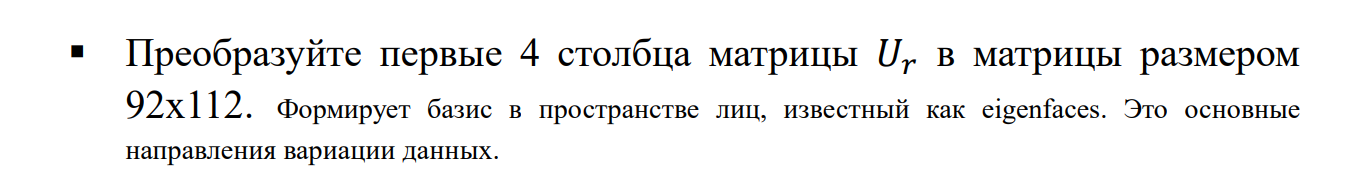

In [37]:
def low_rank_approximation(U, singular_values, VT, r):
    """
    Построение малоранговой аппроксимации с использованием массивов NumPy.
    Принимает массивы NumPy, возвращает массив NumPy.
    """
    logging.info(f"Построение малоранговой аппроксимации для ранга r = {r}.")

    # Проверка корректности ранга
    if r <= 0 or r > len(singular_values):
         logging.error(f"Некорректный ранг аппроксимации r = {r}. Должен быть в диапазоне (0, {len(singular_values)}].")
         raise ValueError(f"Некорректный ранг аппроксимации r = {r}.")

    # Выбор первых r столбцов матрицы U
    Ur = U[:, :r]
    logging.debug(f"Выбраны первые {r} столбцов матрицы U.")

    # Выбор первых r сингулярных значений
    sr = singular_values[:r]
    logging.debug(f"Выбраны первые {r} сингулярных значений.")

    # Выбор первых r строк матрицы VT
    VTr = VT[:r, :]
    logging.debug(f"Выбраны первые {r} строк матрицы VT.")

    # Создание диагональной матрицы из усеченных сингулярных значений
    Sigma_r = np.diag(sr)  # Используем np.diag

    # Вычисление малоранговой аппроксимации: F_star_r = Ur @ Sigma_r @ VTr
    # Используем оператор @ для умножения матриц
    logging.debug("Выполнение умножения Ur @ Sigma_r.")
    Ur_Sigma_r = Ur @ Sigma_r
    logging.debug("Выполнение умножения (Ur @ Sigma_r) @ VTr.")
    F_star_r = Ur_Sigma_r @ VTr

    logging.info(f"Построение малоранговой аппроксимации для ранга r = {r} завершено.")
    return F_star_r, Ur, Sigma_r, VTr

In [38]:
# Construct low-rank approximation for r = 5
r = 5
F_star_r, Ur, Sigma_r, VTr = low_rank_approximation(U, Sigma_diag, VT, r)

print(f"\nМалоранговая аппроксимация F_star_r для r = {r} (NumPy array):")
# Print only a part for large matrices
if F_star_r.shape[0] > 10 or F_star_r.shape[1] > 10:
    print(F_star_r[:10, :10])
else:
    print(F_star_r)

2025-04-30 12:11:16,233 - INFO - Построение малоранговой аппроксимации для ранга r = 5.
2025-04-30 12:11:16,251 - INFO - Построение малоранговой аппроксимации для ранга r = 5 завершено.



Малоранговая аппроксимация F_star_r для r = 5 (NumPy array):
[[-28.13772186 -26.3740252   -6.58232159 -21.36991321 -18.04354806
  -23.91773482 -13.939341   -30.00080737 -39.62551886  44.16540682]
 [-28.39218683 -26.30878849  -6.56257189 -21.44694554 -17.83562614
  -23.73067782 -13.94502262 -30.09309661 -39.45698331  43.8181238 ]
 [-28.11282586 -26.69309437  -7.10415704 -21.39486466 -18.75423067
  -24.49288352 -14.4760832  -30.22617244 -39.95797948  44.62064007]
 [-28.28163845 -26.83606246  -6.78554789 -21.66380803 -18.546182
  -24.45094336 -14.15827743 -30.23393468 -40.16173139  44.54722362]
 [-27.99867907 -26.7602272   -7.08552175 -21.2181383  -18.95248323
  -24.59182956 -14.53936042 -30.17869029 -40.06763919  44.76419993]
 [-27.36907056 -25.84202743  -4.88856113 -20.2072494  -17.17705814
  -22.85653095 -12.65748583 -28.93477033 -39.31905521  43.69017806]
 [-28.39044677 -25.50418478  -4.9861358  -20.54657959 -16.34822735
  -22.15770269 -12.81042642 -29.46172284 -38.702376    42.82485

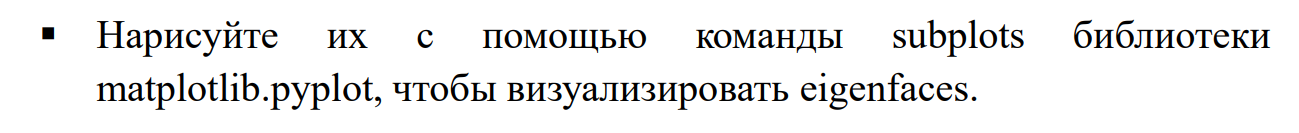

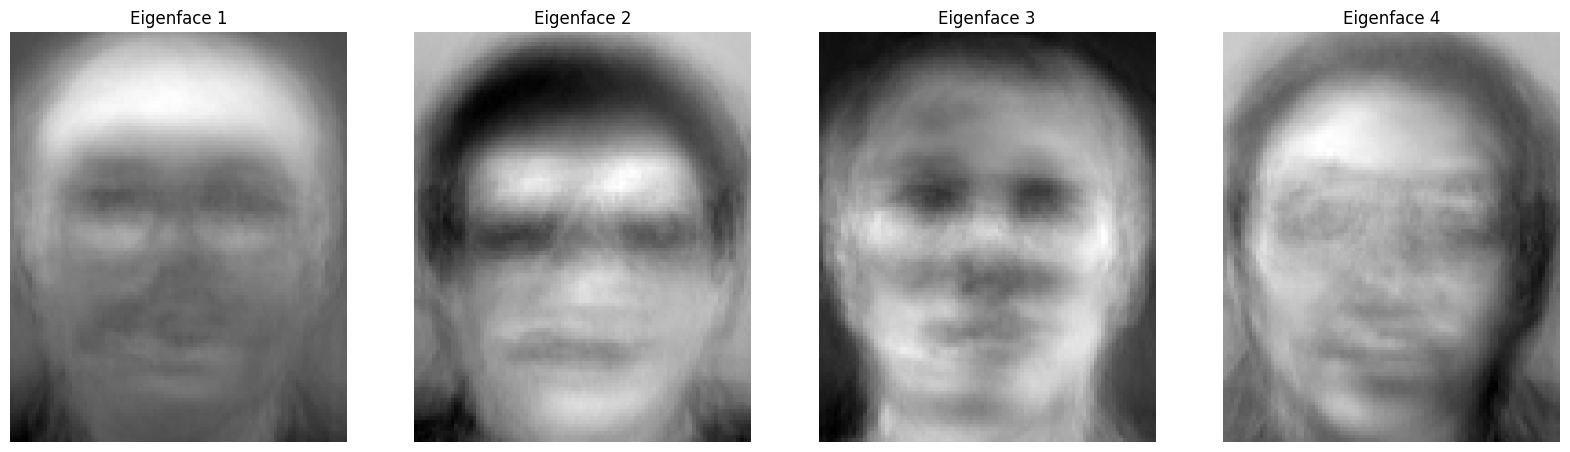

In [46]:
plt.figure(figsize=(20, 8))
for i in range(1,5):
    plt.subplot(1, 4, i)
    plt.imshow(Ur[:,i-1].reshape(112,92), cmap='grey')
    plt.title(f'Eigenface {i}')
    plt.axis('off')
plt.show()

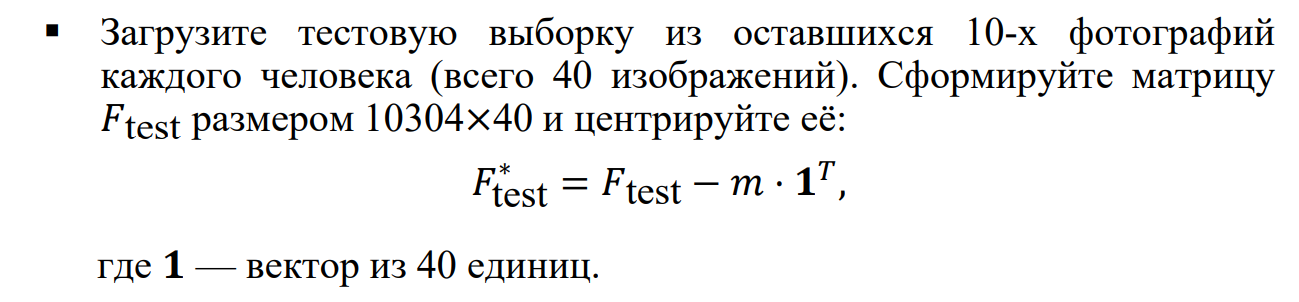

In [40]:
test_images_ravel, test_labels

(array([[ 42, 136,  50, ...,  49, 116, 110],
        [ 41, 136,  46, ...,  48, 116, 112],
        [ 44, 136,  49, ...,  49, 117, 113],
        ...,
        [ 42,  19,  33, ...,  63,  83,  92],
        [ 43,  20,  33, ...,  63,  76,  87],
        [ 41,  21,  41, ...,  56,  77,  90]], dtype=uint8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]))

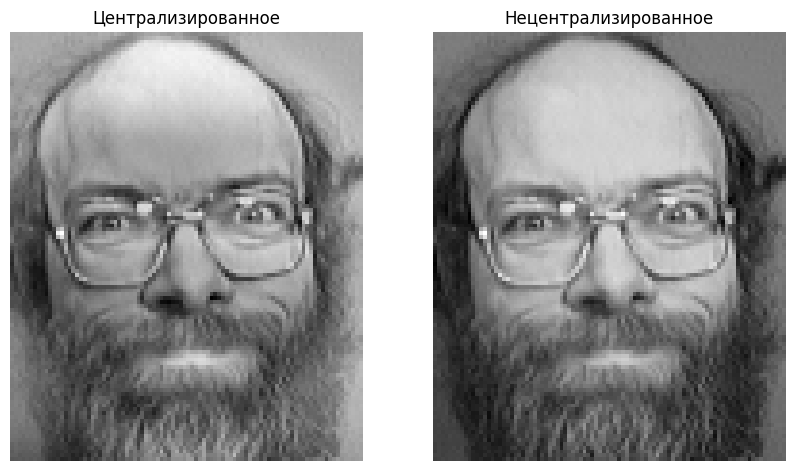

In [41]:
test_images_ravel_star = test_images_ravel - np.repeat(m,test_images_ravel.shape[1]).reshape(10304,40)


idx = 30
imges_to_show = [test_images_ravel_star[:,idx].reshape((112, 92)),test_images_ravel[:,idx].reshape((112, 92))]
labels = ['Централизированное', 'Нецентрализированное']
plt.figure(figsize=(10, 8))
for i in range(1,3):
    plt.subplot(1, 2, i)
    plt.imshow(imges_to_show[i-1], cmap='grey')
    plt.title(labels[i-1])
    plt.axis('off')

plt.show()

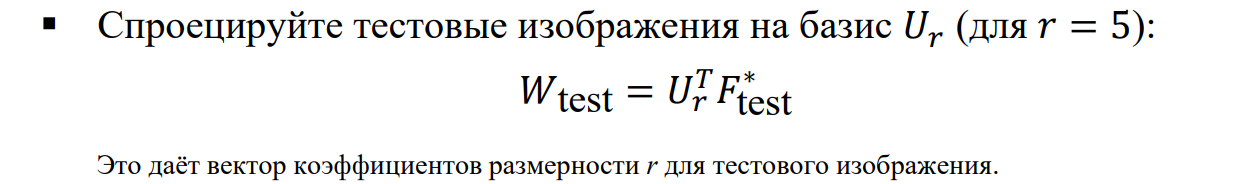

In [42]:
W_test = Ur.T @ test_images_ravel_star

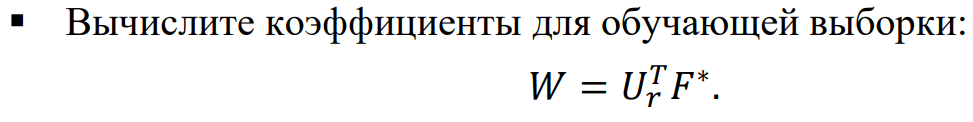

In [43]:
W = Ur.T @ F_star

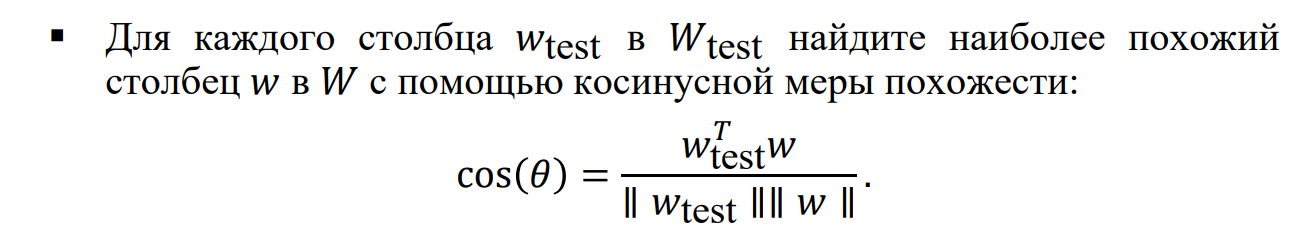

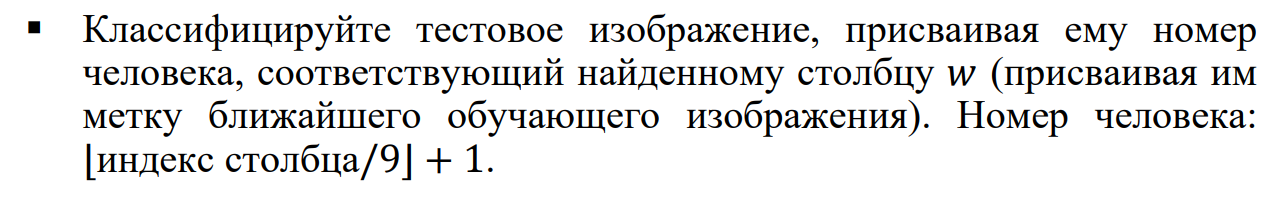

In [ ]:
def nearest_cosine_neighbors(W_test: np.ndarray, W: np.ndarray) -> np.ndarray:
    """
    Для каждого столбца W_test[:, i] находит индекс столбца W[:, j*] c максимальным
    косинус сходством. Возвращает массив shape=(W_test.shape[1],) из j*.

    W_test: массив shape (r, m)
    W:      массив shape (r, n)
    """
    r, m = W_test.shape
    _, n = W.shape
    # Нормируем все столбцы заранее
    W_norm = np.linalg.norm(W, axis=0)
    W_safe = np.where(W_norm < 1e-15, 1e-15, W_norm)
    W_unit = W / W_safe

    idxs = np.empty(m, dtype=int)
    for i in range(m):
        wi = W_test[:, i]
        ni = np.linalg.norm(wi)
        if ni < 1e-15:
            # если нулевой вектор, считаем совпадение с первым
            idxs[i] = 0
            continue
        wi_unit = wi / ni
        sims = wi_unit @ W_unit  # вектор косинус сходств длины n
        idxs[i] = int(np.argmax(sims))
    return idxs

In [48]:
def classify_by_cosine(W_test: np.ndarray, W: np.ndarray) -> np.ndarray:
    """
    Возвращает метки (номера людей) для каждого столбца W_test по правилу
      label = (idx_train // 9) + 1
    где idx_train — найденный индекс столбца в W.
    """
    idxs = nearest_cosine_neighbors(W_test, W)
    labels = (idxs // 9) + 1
    return labels
  

classify_by_cosine(W_test, W)

array([ 1,  2,  3,  4,  5,  6, 29,  8,  9, 10,  3, 11, 13, 14, 15, 40, 17,
       18,  4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 38, 31, 32, 33, 34,
       10, 36, 37, 38, 39, 32])

1. **Плоское представление (вектор) вместо двумерной матрицы**  
   – **Удобство линейной алгебры.** PCA (метод главных компонент) и все операции сводятся к вычислению собственных векторов и собственных значений ковариационной матрицы. Чтобы получить эту матрицу, нам нужно представить каждое изображение как вектор признаков длины $p = h \times w$, а не как матрицу размера $h \times w$.  
   – **Унификация размерности.** Векторное представление позволяет собрать выборку из $n$ изображений в матрицу размера $p \times n$. Тогда каждая колонка — это «развернутое» изображение, а каждая строка — интенсивности одного пикселя по всему набору.  
   – **Пример в коде:**  
   ```python
   F.append(train_images[i].flatten())
   ```  
   где `flatten()` выпукляет матрицу $112\times92$ в вектор длины 10304 .  

2. **Почему первые 9 изображений — для обучения, 10-е — для теста**  
   – **Контроль обобщающей способности.** Для каждого человека мы оставляем одно «ранее не виденное» фото, чтобы проверить, как классификатор справится с новой (не обучающей) вариацией.  
   – **Стабильность оценки.** При равном числе тренировочных и тестовых образцов (9 к 1) мы минимизируем переобучение и при этом имеем представительный тренировочный набор. Если тестовых слишком мало, оценка точности будет слишком шумной; если слишком много — тренировка слабая.  
   – **Влияние на классификатор.**  
     - **Много тренировочных образцов** (увеличить более 9): лучше строятся главные компоненты (eigenfaces), но остаётся риск переобучения к конкретным условиям съёмки.  
     - **Мало тренировочных** (меньше 9): плохая оценка ковариации, eigenfaces «шумят», точность классификации падает.  

3. **Среднее лицо и вычитание среднего**  
   – **Среднее лицо** — это усреднённое по всем тренировочным изображениям вектор:  
     $$
       \bar f = \frac{1}{n} \sum_{i=1}^n f_i,
     $$
     где $f_i$ — вектор-представление $i$-го изображения .  
   – **Зачем вычитать?**  
     1. Убираем общерыночный фон освещённости, тени и среднюю форму лица.  
     2. Центрируем данные в ноль: ковариационная матрица считается по $(f_i - \bar f)$, что критично для корректной работы PCA.  
     – Без центрирования главные компоненты будут захватывать «средние» особенности (основное освещение и форму лица), а не вариации между лицами.  

4. **«Призрачный» вид eigenfaces**  
   – **Интерпретация собственных векторов.** Каждый eigenface — это направление максимальной дисперсии в пространстве пикселей. Это не реальное лицо, а шаблон изменения интенсивности пикселей.  
   – **Частотные паттерны.** Часто первые компоненты отвечают за крупные общие контуры (границы глаз, носа, рта), а дальнейшие — за более мелкие детали. Получаются абстрактные «маски» тёмно-светлых участков, а не узнаваемая фотография.  
   – **«Призрачность».** Поскольку компоненты могут иметь и положительные, и отрицательные значения (отклонения от среднего), при визуализации мы видим эти полутоновые «отрицания» и «положения» как причудливые тени.  

5. **Влияние ранга $r$ в низкоранговой аппроксимации**  
   – **Меньший $r$:**  
     - Быстрее вычисления, меньше памяти.  
     - Аппроксимация «грубее»: теряются мелкие детали лица, классификатор может путать похожие лица.  
   – **Больший $r$:**  
     - Больше компонентов (eigenfaces) сохраняют больше вариаций.  
     - Точность классификации растёт, но появляются шум и переобучение — компонент слишком много подстраиваются под специфический набор тренировочных изображений.  
   – **Компромисс:** найти $r$, при котором накопленная дисперсия (сумма первых $r$ собственных значений) достигает, скажем, 90–95 % от полной.  

6. **Высокое косинусное сходство между векторами коэффициентов**  
   – **Что это значит?** Если два вектора проекции $\alpha$ и $\beta$ (коэффициенты при eigenfaces) имеют косинусное сходство близкое к 1, то они указывают в почти одном направлении в признаковом пространстве.  
   – **В контексте классификации лиц:** два изображения, принадлежащие к одному человеку, будут иметь близкие коэффициенты при сравнении с одним набором eigenfaces. Чем выше косинусная мера, тем сильнее уверенность, что лица одного и того же человека.  

7. **Устойчивость к вариациям освещения, мимики и аксессуаров**  
   – **Освещение.** PCA частично устойчив: первая компонента может захватывать общее изменение яркости, но резкие тени и локальные засветы всё равно воспринимаются как вариации «лица» и влияют на проекции.  
   – **Мимика.** Большие изменения в мимике (улыбка, прищур) меняют ключевые паттерны (контур рта, глаз) сильнее, чем PCA-модель обучена «компенсировать», поэтому классификатор может ошибаться.  
   – **Препятствия (очки, шляпы).** Они создают новые регионы «отклонения» от среднего лица — eigenfaces не знают, как их интерпретировать, поэтому такие случаи резко снижают точность.  
   – **Вывод:** метод работает лучше, когда выборка обучения содержит подобные условия (некоторые варианты освещения/мимики). Но полностью «обобщить» на все возможные вариации средствами только PCA невозможно: обычно дополнительно применяют модели, устойчивые к освещению (например, LBP, SIFT) или глубокие сверточные сети.